In [3]:
import pandas as pd
import seaborn as sns
from gc import collect
from scipy.sparse import csr_matrix
from scipy.sparse import triu as sparse_triu
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
data_directory = '../data/'

In [3]:
patent_classes = pd.read_csv(data_directory+'cpc_current.tsv', sep='\t')

In [4]:
patent_classes = patent_classes[patent_classes['category']=='primary']

In [5]:
patent_classes.drop(['uuid', 'category', 'sequence'], axis=1, inplace=True)

In [6]:
patent_classes['subgroup_aggregated_id'] = patent_classes['subgroup_id'].map(lambda x: x.split('/')[0])

In [ ]:
class_types = ['section', 'subsection', 'group', 'subgroup_aggregated', 'subgroup']

In [ ]:
class_lookups={}
for c in class_types:
    print(c)
    values = sort(patent_classes[c+'_id'].unique())
    n = len(values)
    print(n)
    lookup = pd.Series(index=values,data=arange(len(values)))
    class_lookups[c] = lookup
    patent_classes[c+'_id'] = lookup.ix[patent_classes[c+'_id']].values

section
8


In [ ]:
patent_years = pd.read_csv(data_directory+'patent.tsv', sep='\t', usecols=['id', 'date'])

patent_years.rename(columns={'id':'patent_id'}, inplace=True)
patent_years['patent_id'] = pd.to_numeric(patent_years['patent_id'], errors='coerce')

patent_years['date'] = pd.to_datetime(patent_years['date'], errors='coerce')
patent_years['year'] = pd.DatetimeIndex(patent_years['date']).year

patent_years.dropna(inplace=True)
patent_years.set_index('patent_id', inplace=True)
patent_years.index = patent_years.index.values.astype('int')

In [ ]:
patent_classes['year'] = patent_years.ix[patent_classes.index.values,'year'].values

In [ ]:
years = arange(1976,2016)

In [ ]:
from scipy.sparse import csr_matrix
def cooccurrence_counts(AB, A,B,n=None):
    if n is not None:
        pairings = csr_matrix((ones_like(AB[A]),
                               (AB[A], AB[B])),
                             shape=(AB[A].max()+1,n))
    else:
        pairings = csr_matrix((ones_like(AB[A]),
                               (AB[A], AB[B]))
                              )
    return (pairings.T * pairings)
    
#     return cooccurrences
#     if n is not None:
#         shape=(n,n)
#     all_cooccurrences = zeros((max(classes)+1, max(classes)+1))
#     all_cooccurrences[:present_cooccurrence.shape[0], 
#                           :present_cooccurrence.shape[1]] = present_cooccurrence

In [ ]:
cooccurrences = {}

for c in class_types:
    print(c)
    cooccurrences[c] = {}
    for year in years:
        cooccurrences[c][year] =  cooccurrence_counts(patent_classes[patent_classes['year']==year], 
                                                      'patent_id', c+'_id',
                                                      n=class_lookups[c].shape[0])

In [ ]:
for c in class_types:
    print(c)
    for year in years:
        cooccurrences[c][year].setdiag(0)

In [ ]:
cooccurrences_cumsum = {}
for c in class_types:
    print(c)
    cooccurrences_cumsum[c] = {}
    first_year = True
    for year in years:
        if first_year:
            cooccurrences_cumsum[c][year] = cooccurrences[c][year]
            first_year = False
        else:
            cooccurrences_cumsum[c][year] = cooccurrences[c][year] + cooccurrences_cumsum[c][year-1]

In [ ]:
from igraph import Graph
def network_properties(g, c, df):
    if len(g)==1 or len(unique(g))==1:
        return pd.Series({'density': nan, 
                      'n': 1,
                      'isoclass': 0,
                      })
    else:
        year = df.ix[g.index[0],'year']
        net = sparse_triu(cooccurrences_cumsum[c][year-1][atleast_2d(unique(g)).T,unique(g)])
        sources, targets = net.nonzero()
    #     weights = net[sources, targets]
    #     weights = array(weights)[0] #Need to convert Scipy's matrix format into a form appropriate for igraph
        g = Graph(n=net.shape[0], edges=list(zip(sources, targets)), directed=False, 
    #               edge_attrs={'weight': weights}
                 )
        path_lengths = array(g.shortest_paths())
        return pd.Series({'density': g.density(), 
                          'n': g.vcount(),
                          'isoclass': g.isoclass() if g.vcount()==3 or g.vcount()==4 else 0,
                          'transitivity': g.transitivity_undirected(),
                          'V_density': (path_lengths==2).sum()/2 if g.vcount()>2 else nan,
                          })
import functools

In [ ]:
class_types

In [ ]:
from time import time

network_dict = {}
times = {}
for c in class_types:
    if c=='section':
        continue
    print(c)
    t = time()
    fnc = functools.partial(network_properties, c=c, df=patent_classes)
    network_dict[c] = patent_classes[patent_classes['year']>1976].groupby('patent_id')[c+'_id'].apply(fnc)
    times[c] = time()-t
    print(time()-t)

In [ ]:
for k in network_dict.keys():
    network_dict[k] = pd.DataFrame(network_dict[k]).unstack()

In [ ]:
patent_properties = pd.concat(network_dict, axis=1)
patent_properties.columns = patent_properties.columns.droplevel(level=1)

In [ ]:
patent_properties['year'] = patent_years.ix[patent_properties.index.values,'year'].values

In [ ]:
# c = 'section'

# network_densities = pd.Series(index=patent_years.index)
# for name, g in patent_classes[patent_classes['year']>1976].groupby('patent_id'):
#     year = g['year'].values[0]
#     class_inds = g[c+'_id'].values
#     binary_network = cooccurrences_cumsum[c][year-1][atleast_2d(class_inds).T,class_inds]>0
#     network_densities.ix[name] = binary_network.mean()

Citations Counts
===

In [ ]:
citations = pd.read_csv(data_directory+'uspatentcitation.tsv', sep='\t')

In [ ]:
citations['citation_id'] = pd.to_numeric(citations['citation_id'],errors='coerce')

patent_forward_citations = citations['citation_id'].value_counts().reset_index()

patent_forward_citations.rename(columns={'index':'patent_id',
                                         'citation_id':'count'
                                         },
                                inplace=True
                               ) 

# patent_forward_citations['patent_id'] = pd.to_numeric(patent_forward_citations['patent_id'],
#                                                      errors='coerce')

patent_forward_citations.dropna(inplace=True)
patent_forward_citations['patent_id'] = patent_forward_citations['patent_id'].values.astype('int')
patent_forward_citations.set_index('patent_id', inplace=True)

# patent_forward_citations.index = patent_forward_citations.index.values.astype('int')

In [ ]:
from gc import collect
del(citations)
collect()

In [ ]:
patent_properties['citations_forward'] = patent_forward_citations.ix[patent_properties.index.values].fillna(0).values

In [5]:
store = pd.HDFStore(data_directory+'patent_properties.h5')
# store['patent_properties'] = patent_properties
patent_properties = store['patent_properties']
store.close()

In [ ]:
patent_properties['citations_forward_mean_for_year'] = patent_properties.groupby('year')['citations_forward'].transform('mean')

In [ ]:
patent_properties['citations_forward_relative_to_year'] = patent_properties['citations_forward'].values/patent_properties['citations_forward_mean_for_year'].values

In [ ]:
# import powerlaw
# fit = powerlaw.Fit(patent_properties['citations_forward'].values+1, xmin=1)
# fit.distribution_compare('exponential', 'power_law')

In [68]:
patent_properties[patent_properties[('subgroup','n')]==3][('subgroup', 'isoclass')].value_counts()

0.0    120660
1.0      3811
2.0       241
3.0        21
Name: (subgroup, isoclass), dtype: int64

In [69]:
patent_properties[patent_properties[('subgroup','n')]==4][('subgroup', 'isoclass')].value_counts()

0.0    39971
1.0     1810
2.0      162
5.0       22
6.0       16
4.0        8
3.0        8
7.0        3
9.0        1
Name: (subgroup, isoclass), dtype: int64

0


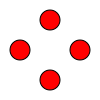

1


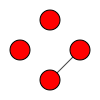

2


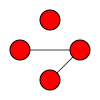

3


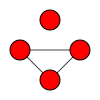

4


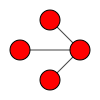

5


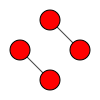

6


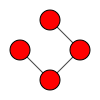

7


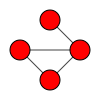

8


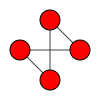

9


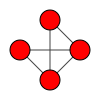

10


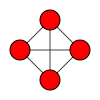

In [34]:
import igraph as ig
from IPython.display import Image
for i in range(11):
    ig.plot(ig.Graph.Isoclass(4, i, directed=False), "isoclass_%d.png"%i, bbox=(100, 100), layout="circle")
    fig = Image(filename=('isoclass_%d.png'%i))
    print(i)
    display(fig)

In [ ]:
patent_properties[((patent_properties[('subgroup','n')]==3) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','isoclass')])['citations_forward_relative_to_year'].mean()

In [ ]:
patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','isoclass')])['citations_forward_relative_to_year'].mean()

In [ ]:
df = patent_properties[((patent_properties[('subgroup','n')]==3) *
                   (patent_properties['year']<2005)
                   )]

sns.violinplot(x=('subgroup', 'isoclass'), y='citations_forward_relative_to_year',
               data=df,
               )

In [ ]:
# http://www.graphclasses.org/smallgraphs.html#nodes4
# http://math.stackexchange.com/questions/599675/why-there-are-11-non-isomorphic-graphs-of-order-4
# http://math.stackexchange.com/questions/683765/how-can-we-make-11-non-isomorphic-graphs-on-4-vertices